In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
print(train_input.shape)
print(train_label.shape)

(25000, 174)
(25000,)


In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name, 'vocab_size': prepro_configs['vocab_size'], 'embedding_dimension':100, 
         'dropout_rate': 0.2, 'lstm_dimension' :150, 'dense_dimension':150, 'output_dimension':1}

### 모델 선언
- LSTM 각 단계에서 현재 정보는 input state, 이전 정보는 hidden state라 함
- LSTM의 매개변수 중 return_sequences은 hidden state의 반환값을 결정하는데
- false일 경우 predict시 마지막 hidden state만 출력됨
- true일 경우 각 time step별 모든 hidden state를 출력함
- 이전의 기록들이 다음 레이어로 들어가기 때문에 LSTM레이어끼리 엮기 위해서는 return_sequence를 사용하여야 함

In [7]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):  # 딕셔너리인 경우에 *이 두개!!꼭!
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1, output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['dense_dimension'], activation=tf.keras.activations.tanh)    #fully-connected layer
        self.fc2 = layers.Dense(kargs['output_dimension'], activation=tf.keras.activations.sigmoid)
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [9]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3) #patience 3번까지 향상되지 않으면 중지, min_delta = 최소 델타값만큼 향상되어야 향상된것을 보겠다
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/rnn_classifier_en -- Folder already exists 



In [10]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5053
Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data_out/rnn_classifier_en\weights.h5
176/176 [==============================] - 112s 636ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5345
Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data_out/rnn_classifier_en\weights.h5
176/176 [==============================] - 112s 637ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8566
Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data_out/rnn_classifier_en\weights.h5
176/176 [==============================] - 113s 643ms/step - loss: 0.3408 - accuracy: 0.8566 - val_l

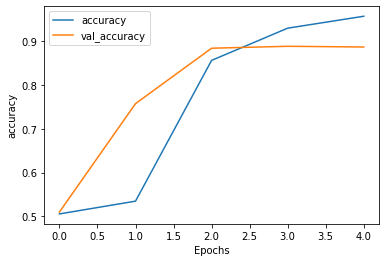

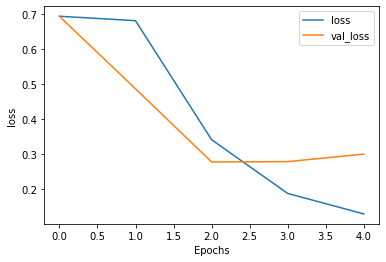

In [11]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [12]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [13]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [14]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [15]:
print(predictions[:10])

[0.9947598  0.01606628 0.19410595 0.5259318  0.9847207  0.7340158
 0.01649895 0.7315027  0.00433642 0.53718805]


In [16]:
import pandas as pd

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)  # 넘파이로 읽을때 객체로 된걸 읽으려면 allow_pickle=true를 해줘야함!
#넘파이 배열 안에 있는 데이터가 판다스 시리즈로 되어있기 때문에 객체로 되어있음

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'id': list(test_id), 'sentiment':list(predictions)})
output.head()

,id,sentiment
0,"""12311_10""",0.994760
1,"""8348_2""",0.016066
2,"""5828_4""",0.194106
3,"""7186_2""",0.525932
4,"""12128_7""",0.984721


In [17]:
output.to_csv(DATA_OUT_PATH + 'review_result_rnn.csv', index=False, quoting=3)